# Intra-annual and annual growing season soil moisture anomalies 

In this notebook we will produce the Intra-annual growing season soil moisture anomalies for a single year. The goal of the workflow is to compare two different approaches within the Euro Data Cube, highlighting the advantages and disadvantages of both approaches.

## Introduction

The Sentinel Hub APIs allow users to programmatically process and integrate satellite data into their own applications on the fly. The Process API is the most commonly- used API in Sentinel Hub as it provides data from satellite imagery: as an image, as source data, or as simple- band combinations of algorithms such as NDVI, LAI, etc. Sentinel Hub API hides the complexity of pre-processing satellite image files and simply makes the data available over chosen area of interest and temporal period of interest. 

`sentinelhub-py` is a Python package allowing to write requests to the Sentinel Hub APIs, thus providing easy integration in Jupyter Notebooks or other Python workflows.

`xcube` is an open- source Python package and toolkit that has been developed to provide Earth observation (EO) data in an analysis-ready form to users. 'xcube' achieves this by carefully converting EO data sources into self-contained data cubes that can be published in the cloud1. The package was developed by Brockmann Consult, a partner in the Euro Data Cube consortium.

`xcube-sh` is an xcube plugin that allows generating data cubes from Sentinel Hub services2. The library queries the requested satellite imagery/raster data from the cloud using Sentinel Hub services and automatically builds a datacube based on the 'xarray' libraries.

`xcube-gen` is a generator service that produces persistent data cubes in object storage from various Earth Observation, model and feature data. This approach allows computing very large datacubes that are not possible to query on-the-fly.

`xcube processing service` is an evolution (currently in the works, planned to be operational by mid-October) of `xcube-gen` allowing user-defined scripting capability. As a consequence, small-scale analysis/processing done with `xcube` can be scaled to larger area using a managed parallelised service.

_Note: the services described above are all included in the Euro Data Cube._

## Rationale

The initial scripts developed as examples for EEA to get familiar with the Euro Data Cube services were based on `xcube-sh`. During the implementation of the steps in the ESA Pilot proposal as well as when exploring the possibility of scaling up the workflow to process the entire dataset (Europe), some challenges were identified. We have reported these to the `xcube` developers and they have taken them into account for development of the "xcube processing service", which is planned to be operational by mid-October and is designed to allow scaling up `xcube` processes to regional scales. In the interest of time we have addressed the current limitations by adding examples on how similar results can be achieved directly with Sentinel Hub, still within the same EDC environment. For transparency purposes we will show an example request for a small test area using `xcube-sh`, followed by an alternative workflow using `sentinelhub-py` along with a custom function to build a tailored datacube.

## Workflow comparison: advantages and constraints

Before running through the two variants of the workflows, a summary of the high-level constraints of each approach is described. Note that there is no need to make a final decision at this point in time. All approaches are inter-connected (e.g. `xcube` using Sentinel Hub to access raster data, SH using xcube to visualise some results, etc.), belonging to the same EDC portfolio of products. And as the services develop further in time, it might make sense to replace some parts of the workflow with another option. There are always several ways to get to the solution and analysts should understand which ones fit best for a specific problem.

### Xcube

- `xcube` builds datacubes from the raw data making it very easy to build datacubes containing the information needed for the analysis.

- The entire workflow is written in Python, ensuring consistency and making the workflow easy to follow.

- Users have limited control over the resampling method when resampling or reprojecting the data. We have noticed small differences in the Start of Season (SOS) and End of Season (EOS) values compared to the original dataset. In certain areas, the lack of control over the resampling method leads to erroneous values being created:
    - close to `nodata` pixels the interpolation creates invalid SOS and EOS values
    - it was observed that certain pixel values were averaged during the resampling. Owing to the format of the SOS and EOS data collections this leads to pixels having meaningless values (e.g. a pixel with an SOS value of 18365 averaged with a pixel value of 19050 leads to a value of 18707. The format being YYDOY: this voids the resulting pixel value).
    
- When building a cube, `xcube` is not able to determine which timestamps contain data or not. This may lead to oversized cubes being created (filled with null data values). The filtering of `nodata` timestamps is computationally costly.

- For upscaling purposes, the workflow will have to be modified to fit the requirements of `xcube processing service`; the exact constraints will be known once the service is operational.

### Sentinelhub-py

- `sentinelhub-py` returns the products directly using the processing power of Sentinel Hub services in the cloud.

- The workflow is scalable with minor modifications: simply switch to the Batch API rather than Process API and run the script for unlimited areas.

- The whole process is being done in the back-end, which sometimes results in lack of user's control of the processing, making it more complicated to debug. The definition of the processing of the end-products within Sentinel Hub ([Evalscripts](https://docs.sentinel-hub.com/api/latest/evalscript/) ; similar to Google Earth Engine scripts), which add to the complexity.


## Recommendations

While xcube processing service is being developed, we recommend to use `sentinelhub-py` library. Once the known constraints of the `xcube` are addressed, we recommend to try to port relevant parts to `xcube`.


1. https://xcube.readthedocs.io/en/latest/overview.html 
2. https://github.com/dcs4cop/xcube-sh

## TOC

1. [Using xcube](#xcube)
2. [Using sentinelhub-py](#shpy)

---
**Before we start**

In the following cell we will install a couple of libraries in our EoXHub environement. These libraries are not essential for the workflow, but allow us to plot results on an interactive map.

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install plotly folium 

## Library imports

In [2]:
# Sentinel Hub
from sentinelhub import (SHConfig, SentinelHubRequest, DataCollection, MimeType, BBox, bbox_to_dimensions)

# Xcube
from xcube_sh.config import CubeConfig
from xcube_sh.cube import open_cube

# Utilities
from pathlib import Path
import tarfile
import json
import datetime as dt
import os
import subprocess


# Numerical computation
import numpy as np
import xarray as xr
import pandas as pd
from numba import jit

# Geospatial libraries
import rasterio as rio
import pyproj
from rasterio.mask import mask
import geopandas as gpd
import shapefile
from shapely.geometry import shape 
from shapely.geometry import Polygon
from osgeo import gdal

# Plotting
import matplotlib.pyplot as plt
import folium

## Credential management
In EDC credentials are automatically setup. In the following cell we pass the crendentials to a dictionnary for `xcube` and to a Sentinel Hub `SHConfig` object for `sentinelhub-py`.

In [3]:
# Pass Sentinel Hub credentials to dictionnary
sh_credentials = dict(client_id=os.environ["SH_CLIENT_ID"],
                      client_secret=os.environ["SH_CLIENT_SECRET"])
config = SHConfig()
config.sh_client_id = os.environ["SH_CLIENT_ID"]
config.sh_client_secret = os.environ["SH_CLIENT_SECRET"]

## Area of interest

Before comparing the two workflows, we will select an Area Of Interest (AOI) that will be used in both examples. The next cells define the bounding box of our AOI and plot it on an interactive map.

In [4]:
# Bounding box in EPSG 3035
aoi_coords = (3891116, 3105416, 3960000, 3140000)


In [5]:
# For plotting the extent on a map, convert to EPSG:4326
proj = pyproj.Transformer.from_crs(3035, 4326, always_xy=True)

aoi_coords_degrees = (proj.transform(aoi_coords[0], aoi_coords[1]),
                      proj.transform(aoi_coords[2], aoi_coords[3]))

# Get center point to centre the map
aoi_centre = [(aoi_coords_degrees[0][1] + aoi_coords_degrees[1][1])/2,
              (aoi_coords_degrees[0][0] + aoi_coords_degrees[1][0])/2]

# Make map
m = folium.Map(aoi_centre, zoom_start=8,tiles='cartodbpositron')

# Plot AOI on the map
folium.Rectangle(
    bounds=[aoi_coords_degrees[0][::-1], aoi_coords_degrees[1][::-1]],
    line_join="round",
    dash_array="5, 5",
    
).add_to(m)

# Display
m

## Specify Sentinel Hub collection ID of ingested datasets

The Timesat and Soil Moisture Anomaly (SMA) collections were ingested by Sentinel Hub services making them accessible in the same way as standard satellite data collections. To access these collections, we need to specify the private collection ID.

In [6]:
# Collection ids
EEA_Soil_Moisture_collection = "8a2e3e0d-7879-4fd8-8a6d-98f51c8056b2"
EEA_timesat_collection = "e541af9d-a9f4-4aba-8952-e5d2a73fcb0d"

## Specify the years of interest

Below the user should define for which years, the cubes should be generated to perform the drought monitoring.

In [38]:
years_range = [2015,2020] #options between 2000-2020 
years_names = list(np.arange(years_range[0],years_range[-1]+1,1))
if years_range[-1] == 2020: # this is needed because the MR-VPP has no data in 2020
    years_range_excl_2020 = [years_range[0],2019]
    years_names_excl_2020 = list(np.arange(years_range_excl_2020[0],years_range_excl_2020[-1]+1,1))

# Section 1: xcube <a id='xcube'></a>

In this section we will use the xcube library to build cube and process the SMA data.

#### Specify projection and resolution

Based on the previously determined bounding box, we set the projection for the datacubes and their spatial resolution.

In [8]:
# Projection code (see https://docs.sentinel-hub.com/api/latest/api/process/crs/)
projection_code = "http://www.opengis.net/def/crs/EPSG/0/3035"

# Spatial resolution in the units of the projection
spatial_res = 500  # in meters

### Setup the Timesat datacube

The timesat collection (which includes the SOS and EOS datasets) contains a dataset for each year. The date is set by default to the 1st January. Here, we will request the `sos` and `eos` bands from the collection for the defined years. 

In [9]:
# SOS and EOS

cube_config_timesat = CubeConfig(dataset_name='CUSTOM',
                             band_names=['sos', 'eos'],
                             bbox=aoi_coords,
                             crs = projection_code,
                             time_range=['{}-01-01'.format(str(years_range[0])), '{}-01-01'.format(str(years_range[-1]))],
                             time_period="1d",
                             spatial_res=spatial_res,
                             band_sample_types='UINT16',
                             collection_id=EEA_timesat_collection
                            )

### Setup the SMA datacube

We request the `anomaly` band of the SMA dataset. Because the season can start the previous year for some of the pixels, we widen the range for the year by querying part of the year before the first year of interest . The index values are retrieved as floats.

In [10]:
# SManom

if years_range[0] == 2000:
    start_date = '{}-01-01'.format(str(years_range[0]))
else:
    start_date = '{}-07-01'.format(str(years_range[0]-1))
end_date = '{}-12-31'.format(str(years_range[-1]))
    
cube_config_sma = CubeConfig(dataset_name='CUSTOM',
                         band_names=['anomaly'],
                         bbox=aoi_coords,
                         crs = projection_code,
                         time_range=[start_date, end_date],
                         time_period="1d",
                         spatial_res=spatial_res,
                         band_sample_types='FLOAT32',
                         collection_id=EEA_Soil_Moisture_collection
                         )

#### Open the `xcube`s containing data based on the preselected criteria

Note that this step is very quick: the `xcube` doesn't fetch the data until a computation is required.

In [11]:
timesat_xcube = open_cube(cube_config_timesat, **sh_credentials)
sma_xcube = open_cube(cube_config_sma, **sh_credentials)

### Set nodata values

The `1d` time_period parameter returns a band for each day in the time-range: `xcube` does not filter the dates for which data is present. Therefore we will remove the timeslices without any data. This operation will take a bit of time: because we are manipulating the data for the first time, the cube has to be computed first.

For the Timesat cube, this step can be performed faster by preselecting the 1st January.

In [12]:
# Select January the first only
timesat_xcube = timesat_xcube.where((timesat_xcube.time.dt.month == 1) & (timesat_xcube.time.dt.day == 1), drop=True)

# Set 0 as nodata values
timesat_xcube = timesat_xcube.where(timesat_xcube['sos'] != 0)  

# Remove nodata values
timesat_xcube = timesat_xcube.dropna("time", how="all")

For the SMA cube, the processing takes longer because the time-slices with data are distributed across the years and the nodata filter has to check every day over the years.

In [13]:
# A trick to reduce the amount of data since SMA is every 10 days
sma_xcube = sma_xcube.where((sma_xcube.time.dt.day == 1) | (sma_xcube.time.dt.day == 11) | (sma_xcube.time.dt.day == 21) | (sma_xcube.time.dt.day == 31), drop=True)

sma_xcube = sma_xcube.dropna("time", how="all")

#### Check the xcubes

In the next three cells the first time slice of the datasets are plotted for visual inspection.

**Soil Moisture Anomaly**

Note that the pixel size appears larger because the Soil Moisture Anomaly resolution is 5 km. Because we are creating a datacube with a higher resolution (500m) the data is resampled.

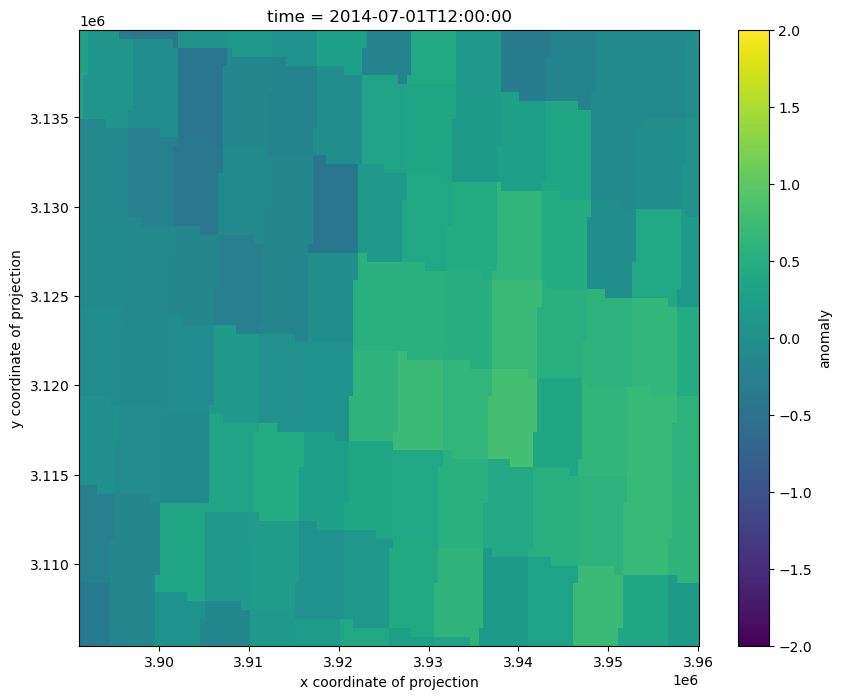

In [14]:
sma_xcube["anomaly"].isel(time=0).plot.imshow(figsize=(10,8), vmin=-2, vmax=2)
plt.show()

**Start of Season**

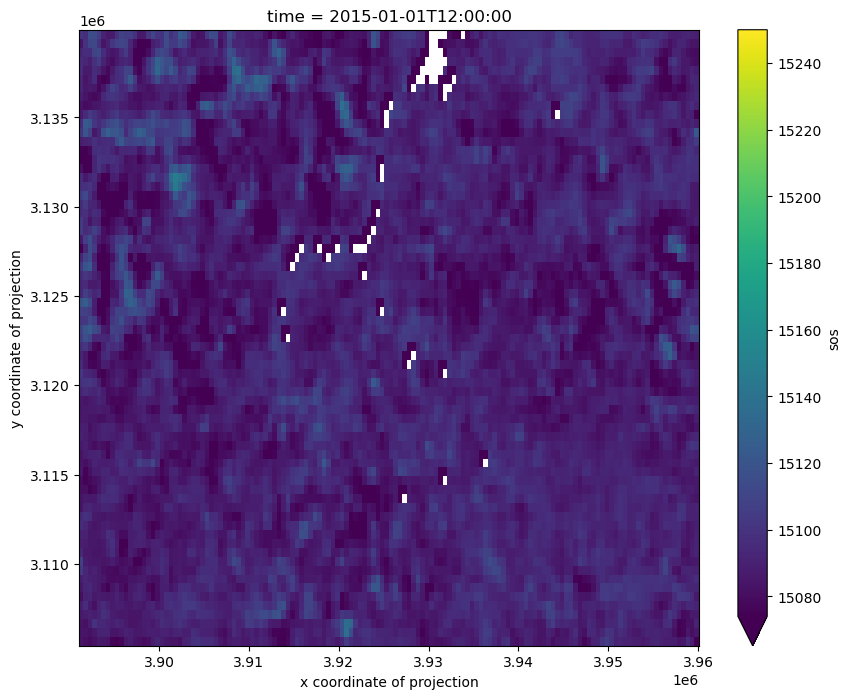

In [15]:
timesat_xcube["sos"].isel(time=0).plot.imshow(figsize=(10,8), vmin=15074, vmax=15250)
plt.show()

**End of Season**

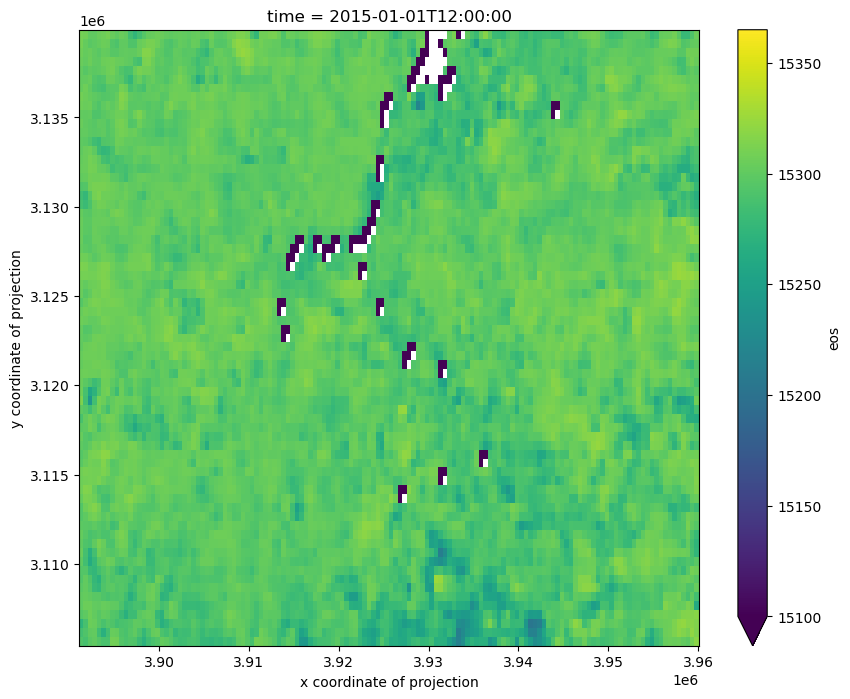

In [16]:
timesat_xcube["eos"].isel(time=0).plot.imshow(figsize=(10,8), vmin = 15100, vmax=15365)
plt.show()

### Filter Soil Moisture Anomaly data

Following the instructions in the proposal, we set a "cutoff" function for SMA values to +3 and -3.

In [17]:
# Filter values larger than 3 and smaller than -3
filter_step_1 = sma_xcube["anomaly"].where(sma_xcube["anomaly"]<=3, 3)
filter_step_2 = filter_step_1.where(filter_step_1 >=-3, -3)

sma_xcube["anomaly_filtered"] = filter_step_2

### Helper functions

In the next cell we define a few functions to manipulate the data collections, this includes manipulating dates, finding positions in the data collections and filtering the data.

In [18]:
def yydoy_to_date(datacube, yydoy_variable, new_var_name, years_interest):
    """YYDOY to DOY.
    
    Converts a datacube variable containing YYDOY dates to Day Of Year values.
    If the date is in the previous year, the DOY is a negative value.
    """
    # Compute the array of sos and initialise an empty array
    data = datacube[yydoy_variable].compute().data
    out_dates = np.zeros_like(data)
    
    # Loop over values in array to convert the YYDOY format to dates
    for h in range(data.shape[0]): #loop also over the years
        current_year = int(years_interest[h])
        for i in range(data.shape[1]):
            for j in range(data.shape[2]):
                if not np.isnan(data[0,i,j]):
                    if current_year >= 2010 and len(str(data[h, i, j])) > 4:
                        year = int(str(int(data[h, i, j]))[0:2])
                        doy = int(str(int(data[h, i, j]))[2:])                       

                    elif current_year == 2000 or len(str(data[h, i, j])) < 4:
                        year = 0
                        doy = int(str(int(data[h, i, j]))[:])

                    else:
                        year = int(str(int(data[h, i, j]))[0:1])
                        doy = int(str(int(data[h, i, j]))[1:])
                        

                    # Here we remove wrong dates created by interpolation
                    if doy <= 365:
                        lastdigits_year = int(str(current_year)[2:])
                        lastdigits_prev_year = int(str(current_year-1)[2:])

                        if year == lastdigits_year:                      
                            out_dates[h, i, j] = doy 
                        elif year == lastdigits_prev_year:
                            out_dates[h, i, j] = doy - 365
                        else:
                            out_dates[h, i, j] = np.nan

                    else:
                        out_dates[h, i, j] = np.nan
    
    datacube[new_var_name] = xr.DataArray(out_dates, dims=['time','y', 'x'], name=new_var_name)
    
def nearest(items, pivot, method=None):
    """Get nearest date.
    
    Fetch nearest date in items, based on pivot. If method is "upper", and the pivot is larger
    than the max value in items, it returns the max of items. If method is "lower" and the pivot is smaller
    than the min value of items, it returns the min of items.
    
    :param items: list of values
    :type items: list
    :param pivot: value to compare to list
    :type pivot: int or float
    :param method: method for values out of bounds
    :type: str (optional)
    :return: nearest value in items
    :rtype: int or float
    """
    # Check for method used
    if (method != "upper" and method != "lower"):
        raise ValueError("Wrong method specified, use upper or lower.")
        
    elif method == "upper":
        if pivot > max(items):
            nrst = max(items)
        else:
            nrst = min([ i for i in items if i >= pivot], key=lambda x:abs(x-pivot))
    else:
        if pivot < min(items):
            nrst = min(items)
        else:
            nrst = min([ i for i in items if i <= pivot], key=lambda x:abs(x-pivot))

    return nrst
 
    
@jit(nopython=True)
def mean_slice(input_array, start_index, end_index, method="mean"):
    """Get mean slice of a 3D array.
    
    Fetch the average of a 3D array (1st dimension) based on start and
    end indices defined in two arrays of the same shape as a slice of the
    3D array.
    
    :param input_array: 3D array to be averaged on the 1st axis
    :type input_array: numpy.ndarray
    :param start_index: array containing start indices
    :type start_index: numpy.ndarray
    :param end_index: array containing end indices
    :type end_index: numpy.ndarray
    :return: Arrays containing average input_array along 1st dimension
    :rtype: numpy.ndarray
    
    """
    if not method in ["mean", "std"]:
        raise ValueError("Wrong method of calculation.")

    # Check size of arrays
    if (input_array[0, :, :].shape != start_index.shape or
        input_array[0, :, :].shape != end_index.shape):
        raise AssertionError("Index arrays not the right shape!")
    
    # Initialise array continaing results
    mean_array = np.zeros_like(start_index).astype(np.float32)
    
    # Loop over 3D raster to calculate the average between indices on axis 0
    for i in range(0, start_index.shape[0]):
        for j in range(0, start_index.shape[1]):
            if (np.isnan(start_index[i, j]) or np.isnan(end_index[i, j] or start_index[i, j] == end_index[i, j])):
                mean_array[i, j] = np.nan
            else:
                if method == "mean":
                    mean_array[i, j] = np.nanmean(input_array[start_index[i, j]: end_index[i, j], i, j])
                else:
                    mean_array[i, j] = np.nanstd(input_array[start_index[i, j]: end_index[i, j], i, j])

    return mean_array
        

def sampling_period_from_sos_to_eos(cube_dates, timesat_cube, method = 'XCUBE'):
    """Get indices in the SMA cube based on SOS&EOS dates over the different years.
    :param cube_dates: list of all SMA observations
    :type input_array: numpy.ndarray
    :param timesat_cube: Xarray dataset containing all SOS/EOS values over the years
    :type timesat_cube: Xarray dataset
    :return: Update of the timesat cube with now info on the start + end index to map SMA over the growing season for each year
    :rtype: Xarray dataset
    
    """
       
    # Convert dates from time variable to DOY
    dates = pd.DatetimeIndex(cube_dates)
    if  min(pd.DatetimeIndex(cube_dates)).year == 2000:
        year_2000_incl = True
    else:
        year_2000_incl = False
    if method ==  "XCUBE":
        SOS_ind_dates = np.zeros_like(timesat_cube['sos_doy_3m'])
        EOS_ind_dates = np.zeros_like(timesat_cube['eos_doy'])
    else:
        SOS_ind_dates = np.zeros_like(timesat_cube['SOS'])
        EOS_ind_dates = np.zeros_like(timesat_cube['EOS'])
        

    for time in range(SOS_ind_dates.shape[0]):
        dates_doy = []
        if method ==  "XCUBE":
            sos_values = timesat_cube.isel(time = time)["sos_doy_3m"].data 
            eos_values = timesat_cube.isel(time = time)["eos_doy"].data 
        else:
            sos_values = timesat_cube.isel(time = time)["SOS"].data 
            eos_values = timesat_cube.isel(time = time)["EOS"].data 
        if time == 0 and year_2000_incl:
            sos_values_flattened = [item if not item <0 else 1 for item in sos_values.flatten()]
        else:
            sos_values_flattened = sos_values.flatten()

        sos_values_flattened = [item if not  item == 0 else np.nan for item in sos_values_flattened] #otherwise error -> need to be investigated!!!

            
        year = pd.DatetimeIndex([timesat_cube.time.data[time]]).year[0]
        for date in dates:
            if date.year == year :
                dates_doy.append(date.timetuple().tm_yday)
            elif date.year == year -1:
                dates_doy.append(date.timetuple().tm_yday -  365)
            else:
                dates_doy.append(np.nan)

        # Calculate the index of the eos date
        SOS_ind_dates[time,:,:] = np.reshape(np.array([dates_doy.index(nearest(dates_doy, x, "lower")) if not np.isnan(x) else np.nan for x in sos_values_flattened]), sos_values.shape)

        # Calculate the index of the eos date
        EOS_ind_dates[time,:,:] = np.reshape(np.array([dates_doy.index(nearest(dates_doy, x, "lower")) if not np.isnan(x) else np.nan for x in eos_values.flatten()]), eos_values.shape)
    
    if method == "XCUBE":
        timesat_cube['SOS_start_ind'] = xr.DataArray(SOS_ind_dates, dims=['time','y', 'x'], name='SOS_start_ind')
        timesat_cube['EOS_start_ind'] = xr.DataArray(EOS_ind_dates, dims=['time','y', 'x'], name='EOS_start_ind')
    else:
        timesat_cube['SOS_start_ind'] = xr.DataArray(SOS_ind_dates, dims=['time','lat', 'lon'], name='SOS_start_ind')
        timesat_cube['EOS_start_ind'] = xr.DataArray(EOS_ind_dates, dims=['time','lat', 'lon'], name='EOS_start_ind')
        


def compute_Z_over_years(input_array, mean, std):
    
    # Initialise array containing results
    z_array = np.zeros_like(input_array).astype(np.float32)
    z_array.fill(np.nan)
    
    # Loop over 3D raster to calculate the average between indices on axis 0
    for i in range(0, input_array.shape[1]):
        for j in range(0, input_array.shape[2]):
            for h in range(0,input_array.shape[0]):
                if np.isnan(input_array[h,i, j]):
                    z_array[h, i, j] = np.nan
                else:
                    z_array[h, i, j] = (input_array[h, i, j] - mean[i,j]) / std[i, j]
    return z_array


def write_raster(input_cube, datatype, output_folder_raster, outname_raster, years_names, band_spec, multi_yrs = True, multi_obs_yr = False):
    """Write values in a datacube to a raster and store it locally. 
    :param input_cube: Xarray dataarray or numpy ndarray containing the data that should be written into a raster
    :param datatype: The datatype in which the raster should be written. This datatype should correspond with the datatype in the input_cube
    :param output_folder_raster: The name of the folder in which the raster will be writen.
    :param outname_raster: The name of the raster file.
    :param years_names: the name of the years for which data is available (only needed in case multiyrs data should be written into the raster)
    :param band_spec: Naming of the band that should be used
    :param multi_yrs: indicates if the data this should be written is for a single time stamp or multitimestamps (default is True)
    :param multi_obs_ry: Indicates if the datacube contaings multiple observation per year or not
    :return: A written raster in the desired folder
    """
        
    transform = rio.transform.from_bounds(aoi_coords[0], aoi_coords[1], aoi_coords[2], aoi_coords[3], sma_SH.lon.size, sma_SH.lat.size)
    if multi_yrs and not multi_obs_yr:
        count = len(years_names)
    elif multi_yrs and multi_obs_yr:
        count = len(input_cube.time)
    else:
        count  = 1
    profile = {'driver': 'GTiff', 'height':sma_SH.lat.size, 'width': sma_SH.lon.size, 'count': count, 'dtype': datatype, 'transform': transform} 
    with rio.open(os.path.join(output_folder_raster.absolute().as_posix(),'{}.tif'.format(outname_raster)),'w', crs = 'EPSG:3035', **profile) as dst:
        if multi_yrs or multi_obs_yr:
            for ix in range(count):
                dst.write(input_cube[ix,:,:], ix+1)
                if multi_obs_yr:
                    dst.set_band_description(ix+1, '{} {}'.format(pd.to_datetime(input_cube.time.data[ix]).strftime('%Y-%m-%d'), band_spec))
                else:
                    dst.set_band_description(ix+1, '{} {}'.format(str(years_names[ix]), band_spec))
        
        else:
            dst.write(input_cube, 1)
            dst.set_band_description(1, '{}'.format(band_spec))   

### Convert SOS and EOS
In the next cell we will create a new variable in the datacube which represents the DOY relative to the start of the chosen year. This means that dates for th year before will be negative. As we have multiple years of interest, we will loop through the years.

In [19]:
yydoy_to_date(timesat_xcube, "sos", "sos_doy", years_names)
yydoy_to_date(timesat_xcube, "eos", "eos_doy", years_names)

In the following cell we will extend the SOS to SOS-3 months. For the time being we cut a corner by simply substracting 90 days to the SOS (very approximate method). 

In [22]:
# Remove 3 months for simplicity we consider 3 months = 30 days
timesat_xcube["sos_doy_3m"] = timesat_xcube["sos_doy"] - 90

### Compute indices of growing season for each pixel

In this step we will compute the indices of SOS-3months and EOS for each pixel in the SMA datacube.

In [23]:
sampling_period_from_sos_to_eos(sma_xcube.time.data,timesat_xcube)

### Plot the data for a given location

In the next cell we will plot the SMA values throughout the season as bars for a given pixel pair.

In [27]:
def plot_pixel_time_series(cube, x_pixel, y_pixel, year, years_names, cube_sos_eos):
    
    index_year_cube = years_names.index(year)
    start_ind_year = cube_sos_eos.isel(time = index_year_cube)['SOS_start_ind'][x_pixel, y_pixel].values
    end_ind_year = cube_sos_eos.isel(time = index_year_cube)['EOS_start_ind'][x_pixel, y_pixel].values
    
    
    if np.isnan(start_ind_year) or np.isnan(end_ind_year):
        print('NO SEASON FOR THIS YEAR')
        return None
    
    start_ind_year = int(start_ind_year)
    end_ind_year  = int(end_ind_year)
    
    SMA_values_pixel_season = cube['anomaly_filtered'][start_ind_year: end_ind_year+1, x_pixel, y_pixel]
    
    doys = [x.timetuple().tm_yday if x.year == year else x.timetuple().tm_yday-365 for x in pd.DatetimeIndex(SMA_values_pixel_season.time.data)]

    
    fig, ax = plt.subplots(figsize=(12,8))
    
    ax.bar(doys, SMA_values_pixel_season.values,width=5)
    ax.set_ylim(-2, 2)
    ax.set_xlabel("Day of Year")
    ax.set_ylabel("Soil Moisture Anomalies (Standardised)")
    ax.set_title("SMA during the growing season of {}".format(str(year)))
    plt.show()

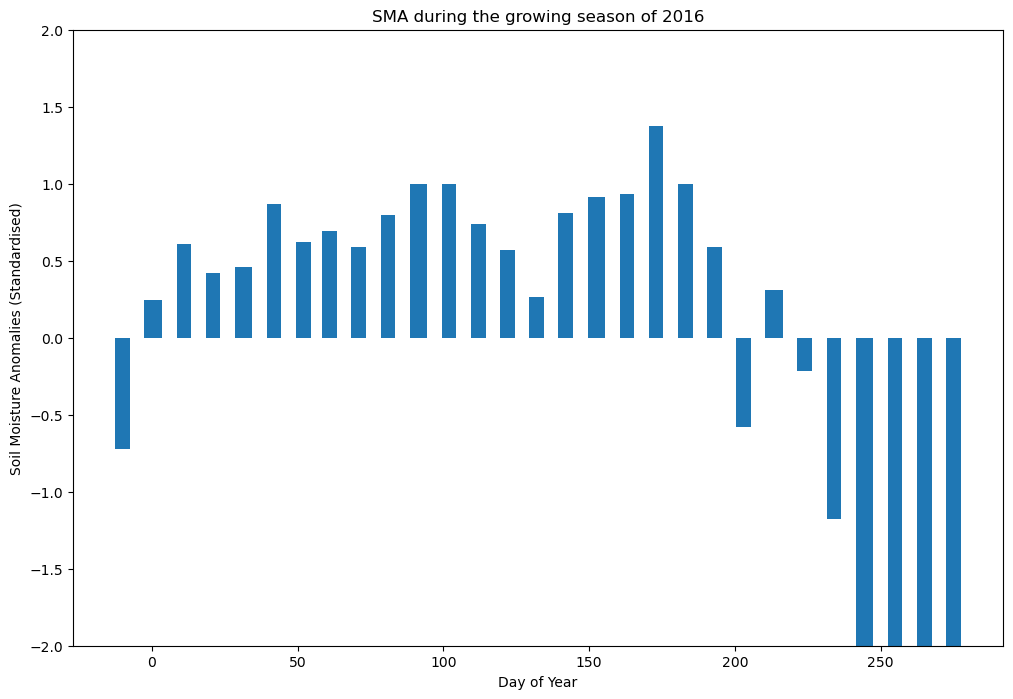

In [28]:
year_Z_score_plotting = 2016
plot_pixel_time_series(sma_xcube, 0, 0, year_Z_score_plotting, years_names, timesat_xcube)

# Section 2: sentinelhub-py  <a id='shpy'></a>



In this section we will use the `sentinelhub-py` library to build a cube and process the SMA data.

## Evalscript

At the heart of Sentinel Hub services lies the Evalscript. An evalscript (or "custom script") is a piece of Javascript code which defines how the satellite data shall be processed by Sentinel Hub and what values the service shall return. 

In this case we willreturn the following bands:

- SMA: Soil Moisture Anomalies (dataset from JRC)
- SOS: the start of season -3 months in DOY (relative to the current year)
- EOS: then end of season in DOY (relative to the current year)

In [29]:

evalscript = """
//VERSION=3

function setup () {
    return {
      input: [
        {
          datasource: 'SM',
          bands: ['anomaly']
        },
        {
          datasource: 'TIMESAT',
          bands: ['sos', 'eos']
        }
      ],
      output: [{
        id: "SMA",
        bands: 1,
        sampleType: SampleType.FLOAT32},
      {
        id: "SOS",
        bands: 1,
        sampleType: SampleType.FLOAT32},
      {
        id: "EOS",
        bands: 1,
        sampleType: SampleType.FLOAT32}
      ],
      mosaicking: 'ORBIT'
    }
  }
  
  function updateOutput (outputs, collection) {
    // Update the bands for SMA and Z
    const subset = ({SMA} = outputs, {SMA})
    const subset2 = ({SOS, EOS} = outputs, {SOS, EOS})
  
    Object.values(subset).forEach(output => {
      output.bands = collection.SM.scenes.length
      }
    )
     Object.values(subset2).forEach(output => {
      output.bands = collection.TIMESAT.scenes.length
      }
    )
    
  }
  
  
  
  function updateOutputMetadata(scenes, inputMetadata, outputMetadata) {
    // Write dates to a json, useful to get the dates
    var all_dates = []
    for (let i=0; i < scenes.SM.scenes.length; i++){
      all_dates[i] = JSON.stringify(scenes.SM.scenes[i].date)
    }
    outputMetadata.userData = {"dates":  all_dates}
  }
  
  
  function evaluatePixel (samples, scenes) {
    // Fetch objects containing dataset content
    const anomalyScenes = scenes.SM.scenes
    const anomalyValues = samples.SM
    const timesatScenes = scenes.TIMESAT.scenes
    const timesatValues = samples.TIMESAT
  
    // Final output where we store all z values for each year.
    // -9999 is the nodata value assigned.
    var SMAinGrowingSeason = new Array(anomalyValues.length).fill(-9999)
    var SOSvaluesyears = new Array(timesatValues.length).fill(-9999)
    var EOSvaluesyears = new Array(timesatValues.length).fill(-9999)

  
    // Loop over the different years for storing SOS/EOS values
    for (let k = 0; k < timesatValues.length; k++){
         // Get the timesat values for a single year
        const { sos, eos } =timesatValues[k]

        // Check if sos and eos are invalid values (0).
        const hasNoSeason = !sos && !eos
        const zeroSeason = sos === eos

        if (!(hasNoSeason || zeroSeason)) {
          // Timesat date
          const selectedYear = timesatScenes[k].date

          // Date for the SOS pixel
          const sosAsDate = parseSeasonAsDate(sos, selectedYear)

          // Date for the EOS pixel
          const eosAsDate = parseSeasonAsDate(eos, selectedYear)

          // Month of the SOS date
          const month = sosAsDate.getMonth()

          // Get SOS three months before SOS.
          sosAsDate.setMonth(sosAsDate.getMonth() - 3) 
          while (sosAsDate.getMonth() === month) {
            sosAsDate.setDate(sosAsDate.getDate() - 1)
          }

          // Get YYDOY of SOS - 3 months
          const sosThreeMonthsAgo = parseDateAsSeason(sosAsDate)

          var rel_sos = relative_doy(sosAsDate, selectedYear.getFullYear())
          SOSvaluesyears[k] = rel_sos
          var rel_eos = relative_doy(eosAsDate, selectedYear.getFullYear())
          EOSvaluesyears[k] = rel_eos
        }


        }    

        

      // Loop over the soil moisture anomaly within the growing season
      for (let i = 0; i < anomalyValues.length; i++) {
        var anomalyValue = anomalyValues[i].anomaly

        // Threshold the anomaly values
        if (anomalyValue < -3) {
          anomalyValue = -3
        }
        if (anomalyValue > 3) {
          anomalyValue = 3
        }

        SMAinGrowingSeason[i] = anomalyValue
      }


    return {
        SMA: SMAinGrowingSeason,
        SOS: SOSvaluesyears,
        EOS: EOSvaluesyears,
    }
  }
  
  function datediff (first, second) {
    // Take the difference between the dates and divide by milliseconds per day.
    // Round to nearest whole number to deal with DST.
    return Math.round((second - first) / (1000 * 60 * 60 * 24))
  }
  
  
  function parseSeasonAsDate (season, year) {
    const selectedYear = year.getFullYear()
    if (selectedYear === 2000) {
      if (season.toString().length > 3) {
        return new Date('2000-01-01')
      }
      return getDateFromDay(2000, season)
    }
  
    if (selectedYear === 2001) {
      const firstDigitOfYear = parseInt(season.toString().slice(0, 1))
      if (firstDigitOfYear !== 1) {
        return getDateFromDay(2000, season)
      }
    }
  
    if (selectedYear < 2010 || season.toString().length  == 4) {
      const day = season.toString().slice(1)
      const lastDigitOfYear = season.toString().slice(0, 1)
      const seasonYear = parseInt(`200${lastDigitOfYear}`, 10)
      return getDateFromDay(seasonYear, day)
    }
  
    const day = season.toString().slice(2)
    const lastDigitsOfYear = season.toString().slice(0, 2)
    const seasonYear = parseInt(`20${lastDigitsOfYear}`, 10)
    return getDateFromDay(seasonYear, day)
  }
  
  function relative_doy(inDate, baseYear){
    // From a date compute relative DOY compared to
    // 1st January of a given year
    var now = new Date(inDate.getFullYear(), inDate.getMonth(), inDate.getDay())
    var start = new Date(baseYear, 0, 0);
    var diff = now - start;
    var oneDay = 1000 * 60 * 60 * 24;
    var day = Math.floor(diff / oneDay);
    
    return day
  }
  
  function getDateFromDay (year, day) {
    const date = new Date(year, 0) // initialize a date in `year-01-01`
    return new Date(date.setDate(day)) // add the number of days
  }
  
  
  function parseDateAsSeason (date) {
    const selectedYear = date.getFullYear()
    const dayOfYear = dateToDayOfYear(date)
    if (selectedYear === 2000) {
      return dayOfYear 
    }
  
    if (selectedYear < 2010) {
      const formattedYear = selectedYear.toString().slice(3, 4)
      return parseInt(`${formattedYear}${dayOfYear}`, 10)
    }
  
    const formattedYear = selectedYear.toString().slice(2, 4)
    return parseInt(`${formattedYear}${dayOfYear}`, 10)
  }
  
  function dateToDayOfYear (date) {
    var start = new Date(date.getFullYear(), 0, 0)
    var diff =
      date -
      start +
      (start.getTimezoneOffset() - date.getTimezoneOffset()) * 60 * 1000
    var oneDay = 1000 * 60 * 60 * 24
    var day = Math.floor(diff / oneDay)
    return day
  }
"""

## AOI

Based on the common AOI defined at the start of this Jupyter Notebook, we will create a `sentinelhub-py` object that will be passed to the request.

In [30]:
# Resolution in meters
aoi_resolution = 500
# Bounding box
aoi_bbox = BBox(bbox=aoi_coords, crs="EPSG:3035")
# Resulting image size
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=aoi_resolution)

## Outputs

We will return the Sentinel Hub results as tiffs in order to convert them to a datacube. Here we set the output folder that will contain the results.

In [31]:
output_folder = Path("./Z_data")

## Request

To send the Evalscript to Sentinel Hub services we need to specify a certain number of input parameters. Just as we did with the `xcube` configuration, we specify the input data collections, the dates requested and the AOI. In addition, we specify the output files and their format for saving the data.


In [32]:
def create_SHUB_request_over_years(years_range):
    if years_range[0] == 2000: #to add because we always consider a period of 3M before SOS, so this step is needed to avoid exceeding data availability range
        date_start_SMA = '2000-01-01'
    else:
        date_start_SMA = '{}-07-01'.format(str(years_range[0]-1))
        

    request_true_color = SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection = DataCollection.define_byoc(EEA_Soil_Moisture_collection),
                time_interval=(date_start_SMA, '{}-12-31'.format(str(years_range[-1]))),
                upsampling="NEAREST", ## might be changed to bilinear
                downsampling="NEAREST",
                other_args = {"id": "SM"}
            ),
            SentinelHubRequest.input_data(
                data_collection=DataCollection.define_byoc(EEA_timesat_collection),
                time_interval=('{}-01-01'.format(str(years_range[0])), '{}-01-01'.format(str(years_range[-1]))), 
                upsampling="NEAREST",
                downsampling="NEAREST",
                 other_args = {"id": "TIMESAT"}
            ),
        ],
        responses=[
        SentinelHubRequest.output_response('SMA', MimeType.TIFF),
        SentinelHubRequest.output_response('SOS', MimeType.TIFF),
        SentinelHubRequest.output_response('EOS', MimeType.TIFF),
        SentinelHubRequest.output_response('userdata', MimeType.JSON),


        ],
        bbox=aoi_bbox,
        size=aoi_size,
        config=config,
        data_folder=str(output_folder)

    )
    return request_true_color

## Run the request

In [33]:
request_true_color = create_SHUB_request_over_years(years_range)
true_color_imgs = request_true_color.get_data(save_data=True)

## Build a datacube

The next series of functions will allow us to build datacubes in the same way `xcubes` does, with more control over the options.

In [34]:
def create_cube(inpath, file, variables, year=2019):
    """Create a datacube based on SH services."""
    
    # Get full path of folder of interest
    folder_path = inpath.joinpath(file.split("/")[0])
    
    # Unzip the tar
    if inpath.joinpath(file).name.endswith(".tar"):
        tar = tarfile.open(str(inpath.joinpath(file)), "r:")
        tar.extractall(path=folder_path)
        tar.close()
    
    # Search for tiff files
    tiff_files = list(folder_path.glob('**/*.tif'))
    
    selected_tiff = [x for x in tiff_files if x.stem in variables]   
       
    # Search for metadata files
    meta_files =  list(folder_path.glob('**/userdata.json'))
    
    
    # Read dates from metadata file and convert to pandas series
    with open(meta_files[0]) as f:
        userdata = json.load(f)
    
    date_list = pd.DataFrame([dt.datetime.strptime(x, '"%Y-%m-%dT%H:%M:%S.%fZ"') for x in userdata["dates"]])
    
    # Get metadata off of the first raster in the list
    lat, lon = get_meta(selected_tiff[0])
    
    # Get a dictionnary with the values from all the rasters
    raster_values = read_raster_list(selected_tiff)

    # Build xarray dataset
    datasets = {}
    for dataset in raster_values:
        
        # Set the -9999 to no data
        raster_nodata = raster_values[dataset]
        raster_nodata[raster_nodata == -9999] = np.nan
        
        # Build xarray
        datasets[dataset] =  xr.DataArray(data = raster_nodata,
                                          dims = ['time', 'lat', 'lon'],
                                          coords = {'time': date_list[0], 'lon': lon, 'lat': lat},
                                          attrs  = {'_FillValue': -9999})
    
    return xr.Dataset(datasets)
    
    
def create_doy_cube(inpath, file, variables, year=2019):
    """Create a datacube based on SH services."""
    
    # Get full path of folder of interest
    folder_path = inpath.joinpath(file.split("/")[0])
    
    # Unzip the tar
    if inpath.joinpath(file).name.endswith(".tar"):
        tar = tarfile.open(str(inpath.joinpath(file)), "r:")
        tar.extractall(path=folder_path)
        tar.close()
    
    # Search for tiff files
    tiff_files = list(folder_path.glob('**/*.tif'))
    
    selected_tiff = [x for x in tiff_files if x.stem in variables]   
          
    # Get metadata off of the first raster in the list
    lat, lon = get_meta(selected_tiff[0])
    
    # Get a dictionnary with the values from all the rasters
    raster_values = read_raster_list(selected_tiff)

    # Build xarray dataset
    datasets = {}
    for dataset in raster_values:
        
        # Set the -9999 to no data
        raster_nodata = raster_values[dataset]
        raster_nodata[raster_nodata == -9999] = np.nan
        
        # Build xarray
        datasets[dataset] =  xr.DataArray(data = raster_nodata,
                                          dims = ['time', 'lat', 'lon'],
                                          coords = {'time': np.array([dt.datetime(item, 1, 1) for item in year]), 'lon': lon, 'lat': lat},
                                          attrs  = {'_FillValue': -9999})
    
    return xr.Dataset(datasets)


def get_meta(in_raster):
    """Get latitude and longitude data from a raster."""
    
    with rio.open(str(in_raster)) as src:
        
        # Obtain tiles' height and width
        height = src.height
        width = src.width

        # Create zero-array for coordinates' storage
        lon = np.zeros(width)
        lat = np.zeros(height)

        # Obtain the location of the center of each pixel on x and y axis to calculate lon and lat.
        x_li = [(x + 0.5) for x in range(width)]
        y_li = [(y + 0.5) for y in range(height)]

        # Get lon range
        for x in x_li:
            coords = src.transform * (x, 0.5)
            lon[int(x - 0.5)] = coords[0]

        # Get lat range
        for y in y_li:
            coords = src.transform * (0.5, y)
            lat[int(y - 0.5)] = coords[1]
    
    return lat, lon


def read_raster_list(input_list):
    """Read a list of tif and return the array and the name."""
    
    arrays = {}
    
    for elem in input_list:
        with rio.open(str(elem)) as src:
            arrays[elem.stem] = src.read()
            
    return arrays

In the next two cells we build a cube containing SMA values, and a cube containing SOS and EOS values.

In [39]:
timesat_SH = create_doy_cube(output_folder, request_true_color.get_filename_list()[0], ["SOS", "EOS"], year =years_names_excl_2020)

In [40]:
sma_SH = create_cube(output_folder, request_true_color.get_filename_list()[0], ["SMA"])

In [41]:
#write to raster
output_folder_raster = Path("./{}/{}".format('output', 'rasters'))
os.makedirs(output_folder_raster, exist_ok= True)
outname_raster = 'SMA' 
datatype = rio.float32
band_spec = 'SMA'
write_raster(sma_SH['SMA'], datatype, output_folder_raster, outname_raster, years_names,band_spec, multi_obs_yr= True)

#### Check the datacubes

In the next three cells the first time slice of the datasets are plotted for visual inspection.

**Soil Moisture Anomaly**

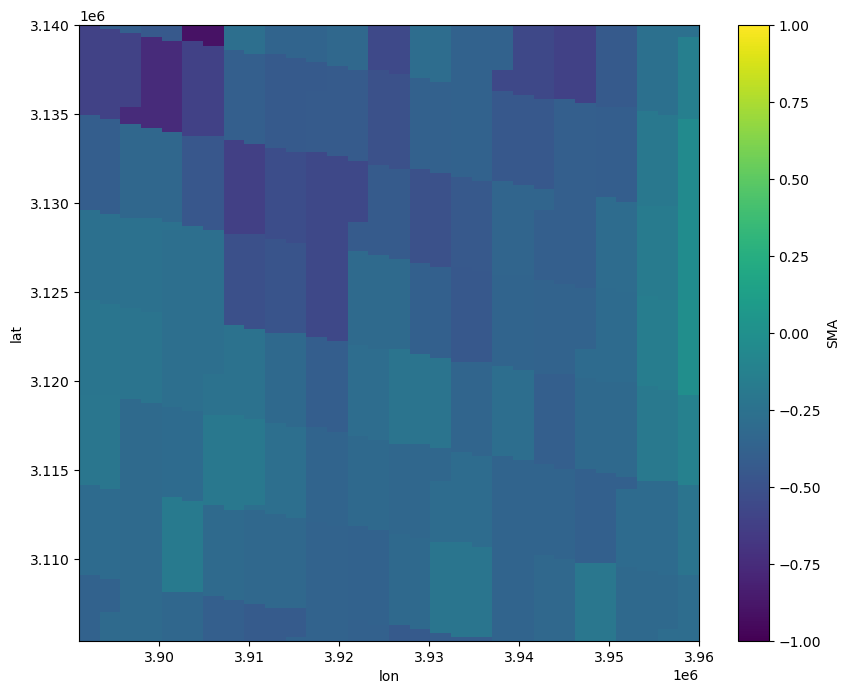

In [42]:
sma_SH["SMA"].mean(axis=0).plot.imshow(figsize=(10,8), vmin=-1, vmax=1)
plt.show()

**Start of Season**

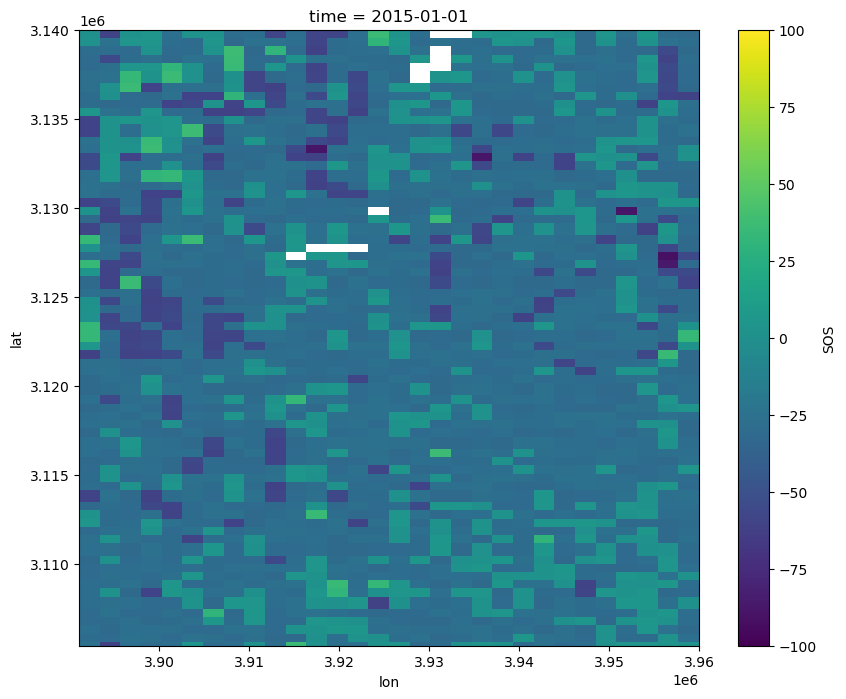

In [43]:
timesat_SH["SOS"].isel(time=0).plot.imshow(figsize=(10,8), vmin=-100, vmax=100)
plt.show()

**End of Season**

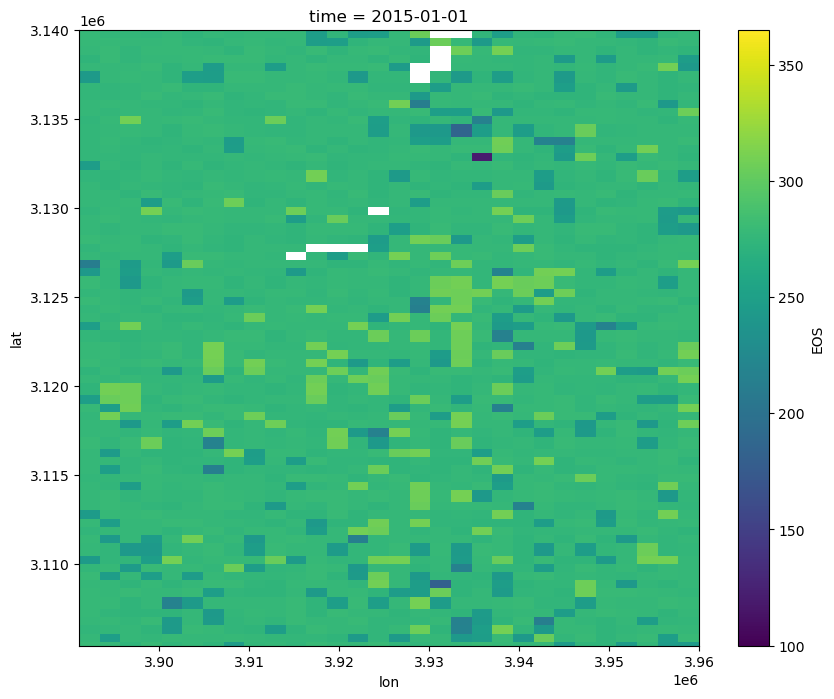

In [44]:
timesat_SH["EOS"].isel(time=0).plot.imshow(figsize=(10,8), vmin=100, vmax=365)
plt.show()

## Comparison

Finally, we plot the SMA timeseries in the growing season for a given coordinate pair based on both methods.
Test plot the two methods for a given location

In [45]:
latitude = 389150
longitude = 3105430

In this step we will compute the indices of SOS-3months and EOS for each pixel in the SMA datacube.

In [46]:
sampling_period_from_sos_to_eos(sma_SH.time.data, timesat_SH, method = 'SHUB')

In [48]:
def comparison_plot(sma_sh, sma_xcube, timesat_sh, timesat_xcube, year_comparison, latitude, longitude, years_names):
    fig, ax = plt.subplots(figsize=(12,8))
    index_year_cube = years_names.index(year_comparison)
    
    start_ind_year_sh = timesat_sh.isel(time = index_year_cube).sel(lat = latitude, lon = longitude, method = 'nearest')['SOS_start_ind'].values
    end_ind_year_sh = timesat_sh.isel(time = index_year_cube).sel(lat = latitude, lon = longitude, method = 'nearest')['EOS_start_ind'].values
    start_ind_year_xcube = timesat_xcube.isel(time = index_year_cube).sel(y = latitude, x = longitude, method = 'nearest')['SOS_start_ind'].values
    end_ind_year_xcube = timesat_xcube.isel(time = index_year_cube).sel(y = latitude, x = longitude, method = 'nearest')['EOS_start_ind'].values
    

    if np.isnan(start_ind_year_sh) or np.isnan(end_ind_year_sh):
        print('NO GS AVAILABLE FOR LOCATION')
        return []
    if np.isnan(start_ind_year_xcube) or np.isnan(end_ind_year_xcube):
        print('NO GS AVAILABLE FOR LOCATION')
        return []
    
    
    SMA_values_season_xcube = sma_xcube['anomaly_filtered'].sel(y = latitude, x = longitude, method = 'nearest')[int(start_ind_year_xcube): int(end_ind_year_xcube)+1]
    SMA_values_season_sh = sma_sh['SMA'].sel(lat = latitude, lon = longitude, method = 'nearest')[int(end_ind_year_sh): int(start_ind_year_sh)+1]
    
    doys_xcube = [x.timetuple().tm_yday if x.year == year_comparison else x.timetuple().tm_yday-365 for x in pd.DatetimeIndex(SMA_values_season_xcube.time.data)]
    doys_sh = [x.timetuple().tm_yday if x.year == year_comparison else x.timetuple().tm_yday-365 for x in pd.DatetimeIndex(SMA_values_season_sh.time.data)]
    

    ax.plot(doys_sh, SMA_values_season_sh.values, color="forestgreen", label="SH", linestyle = '--')
    ax.plot(doys_xcube, SMA_values_season_xcube.values, color="red", label="Xcube")
    ax.legend()
    ax.set_xlabel("Day of Year [year {}]".format(str(year_comparison)))
    ax.set_ylabel("Soil moisture anomaly")
    ax.set_title("Comparison of soil moisture anomalies during the growing season of {} for both methods".format(str(year_comparison)))
    plt.show()

XCUBE SOS DAY IS: -7.0
SH SOS DAY IS: -25.0


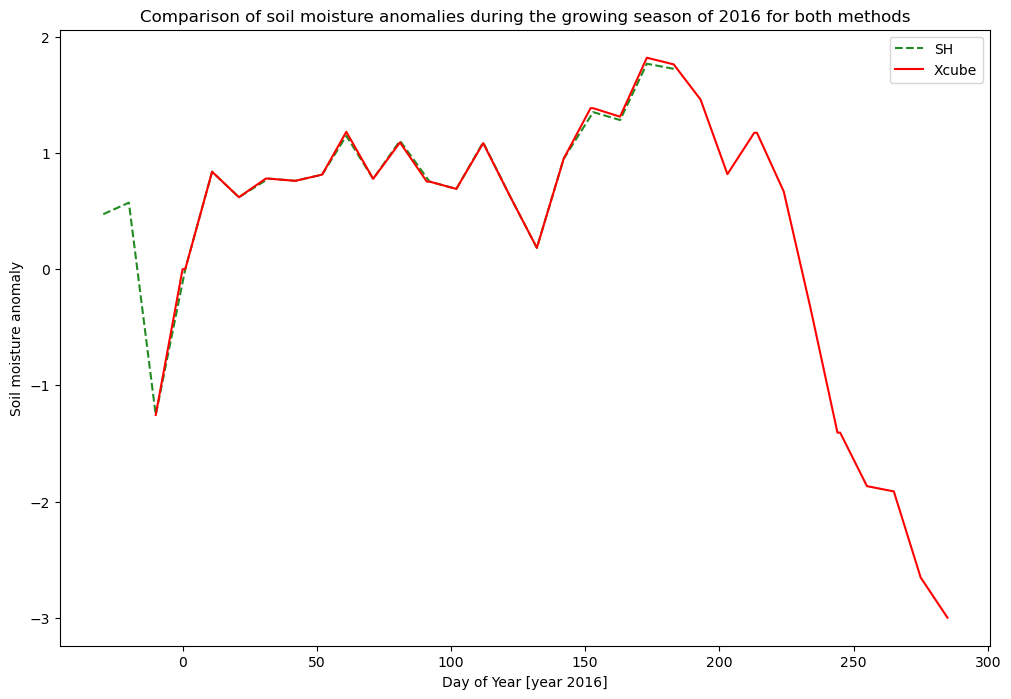

In [49]:
print('XCUBE SOS DAY IS: {}'.format(str(timesat_xcube['sos_doy_3m'].sel(y=latitude, x=longitude, method="nearest").values[0])))
print('SH SOS DAY IS: {}'.format(str(timesat_SH['SOS'].sel(lat=latitude, lon=longitude, method="nearest").values[0])))
comparison_plot(sma_SH, sma_xcube, timesat_SH, timesat_xcube, 2016, latitude, longitude, years_names)

The small differences in the two curves are due to the interpolation in `xcube` over which the user has no control. We also notice that the SH curve includes more of data for the season. After thourough testing it appears that the method is correct in the `sentinelhub-py` version. If we choose to pursue with `xcube` the season selection bug will be fixed in the next iteration.

## Compute annual growing season anomaly

In the next cells the annual growing season anomaly will be determined by making use of the standardises SMA values. 

#### ESTIMATE ANOMALY OF EACH GROWING SEASON OVER THE YEARS

The code below will calculate the average SMA for each growing season

In [50]:
def SMA_annual_anomaly(dir_meta_loc, z_cube, sos_eos_cube, years_names):
    datasets  = {}
    lat, lon  =get_meta(dir_meta_loc)

    sampling_period_from_sos_to_eos(z_cube.time.data, sos_eos_cube, method = 'SHUB')
    SMA_avg_season = np.zeros_like(sos_eos_cube['SOS'].compute().data)
    for year in years_names:
        start_ind = sos_eos_cube['SOS_start_ind'].isel(time = years_names.index(year)).values
        end_ind = sos_eos_cube['EOS_start_ind'].isel(time = years_names.index(year)).values
        SMA_avg_season[years_names.index(year),:,:] =  mean_slice(z_cube["SMA"].compute().data, end_ind, start_ind) # start and end index switched because of recent -> old order of time range

    datasets['SMA_average_season'] = xr.DataArray(data = SMA_avg_season, 
                                       dims = ['time', 'lat', 'lon'],
                                       coords = {'time': np.array([dt.datetime(item, 1, 1) for item in years_names]),'lat': lat,'lon': lon},
                                       attrs  = {'_FillValue': -9999})
    cube_annual = xr.Dataset(datasets)
    #cube_annual['SMA_average_season_years'] = cube_annual['SMA_average_season'].mean(axis = 0)
    #cube_annual['SMA_std_season_years'] = cube_annual['SMA_average_season'].std(axis = 0)

    #cube_annual["Z_annual_growing_season_anomaly"] = xr.DataArray(compute_Z_over_years(cube_annual["SMA_average_season"].compute().data, 
                                                        #cube_annual["SMA_average_season_years"].compute().data,
                                                        #cube_annual["SMA_std_season_years"].compute().data),
                                              #dims=['time','lat', 'lon'],
                                              #coords = {'time': np.array([dt.datetime(item, 1, 1) for item in years_names]),'lat': lat,'lon': lon})
    return cube_annual

In [52]:
dir_meta = os.path.join(output_folder, os.path.split(request_true_color.get_filename_list()[0])[0] + '/EOS.tif')
sma_cube_sh_annual_anomaly = SMA_annual_anomaly(dir_meta, sma_SH, timesat_SH, years_names_excl_2020)

In [53]:
#write to raster
output_folder_raster = Path("./{}/{}".format('output', 'rasters'))
os.makedirs(output_folder_raster, exist_ok= True)
outname_raster = 'Ann_SMA_avg' 
datatype = rio.float32
band_spec = 'ANNUAL AVERAGE SMA IN GS'
write_raster(sma_cube_sh_annual_anomaly['SMA_average_season'], datatype, output_folder_raster, outname_raster, years_names_excl_2020,band_spec)

##### PLOT ANNUAL GROWING SEASON SOIL MOISTURE ANOMALIES

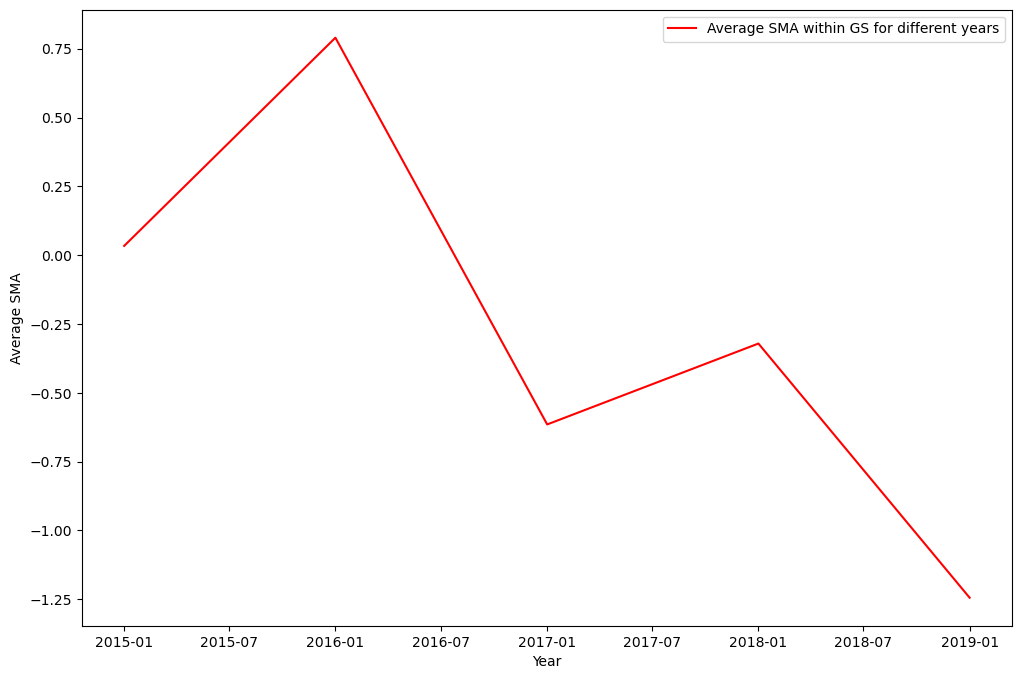

In [54]:
#take a random pixel
import datetime
fig, ax = plt.subplots(figsize=(12,8))

sma_anomaly_years = sma_cube_sh_annual_anomaly["SMA_average_season"]
sma_anomaly_years_pixel = sma_cube_sh_annual_anomaly.sel(lat=latitude, lon=longitude, method="nearest")


years_sma_annual_anomaly = [x for x in pd.DatetimeIndex(sma_anomaly_years.time.data)]
ax.plot(years_sma_annual_anomaly, sma_anomaly_years_pixel["SMA_average_season"], color="red", label="Average SMA within GS for different years")
ax.legend(loc = 'upper right')
ax.set_xlabel("Year")
ax.set_ylabel("Average SMA")
plt.show()

## ANNUAL AND LONG-TERM AVERAGE DROUGHT INTENSITY

In a next step, the SMA values could be used to detect drought intensity for each growing season as well as long-term average drougth intensity 

In [55]:
def calc_annual_drought_intensity(cube_moisture, cube_phenology, years_names):
    drought_intensity_values = np.zeros_like(cube_phenology['SOS'].compute().data)
    for time in range(len(cube_phenology.time.data)):
        start_ind_season = cube_phenology.isel(time = time)['SOS_start_ind']
        end_ind_season = cube_phenology.isel(time = time)['EOS_start_ind']
        for i in range(drought_intensity_values.shape[1]):
            for j in range(drought_intensity_values.shape[2]):
                if not np.isnan(end_ind_season[i,j].values)  and not np.isnan(start_ind_season[i,j].values):
                    drought_intensity = np.nanmin(cube_moisture['SMA'][int(end_ind_season[i,j].values):int(start_ind_season[i,j].values)+1,i,j])

                    if drought_intensity >= 0:
                        drought_intensity = 0
                else:
                    drought_intensity = np.nan
                drought_intensity_values[time, i, j] = drought_intensity
                
    cube_drought_intensity = xr.DataArray(drought_intensity_values, dims = ['time', 'lat', 'lon'], name = 'Annual drought intensity',
                                        coords = {'time': np.array([dt.datetime(item, 1, 1) for item in years_names]),'lat': cube_phenology.lat,'lon': cube_phenology.lon}) 
        
    return cube_drought_intensity 

In [56]:
annual_drought_intensity = calc_annual_drought_intensity(sma_SH, timesat_SH, years_names_excl_2020)
long_term_drought_intensity  = annual_drought_intensity.mean(axis = 0)

In [58]:
#write to raster
output_folder_raster = Path("./{}/{}".format('output', 'rasters'))
os.makedirs(output_folder_raster, exist_ok= True)

### annual drought intensity 
outname_raster = 'Ann_drought_intensity' 
datatype = rio.float32
band_spec = 'ANNUAL DROUGHT INTENSITY'
write_raster(annual_drought_intensity, datatype, output_folder_raster, outname_raster, years_names_excl_2020,band_spec)

### long-term drought intensity
outname_raster = 'Long_term_drought_intensity' 
datatype = rio.float32
band_spec = 'LONG TERM DROUGHT INTENSITY'
write_raster(long_term_drought_intensity, datatype, output_folder_raster, outname_raster, years_names_excl_2020,band_spec, multi_yrs= False)

## ANNUAL AND LONG-TERM AVERAGE DROUGHT HAZARD
Furthermore, SMA values could be used to detect the area under drought hazard. Therefore, in the next cells the pixels with SMA values below a certain threshold within the growing season will be aggregated on CLC level in a NUTS3 region.  

In [59]:
def find_overlap_NUTS3(bbox_info, path_polygons):
    """
    Function used to detect overlap of a bounding box with polygons in a shapefile
    :param bbox_info: 4 corner coordinates of the BBOX on which the clipping should be performed
    :param path_polygons: directory of the polygon file, which will be used to define the overlap
    :return: a list with the name of the polygons that overlap with the bounding box 
    """

    dir_NUTS3 = Path(path_polygons).absolute().as_posix()
    shp = shapefile.Reader(dir_NUTS3)
    all_shapes = shp.shapes()
    all_records = shp.records()

    shape_bbox = Polygon([(bbox_info[0], bbox_info[3]), (bbox_info[2], bbox_info[3]), (bbox_info[2], bbox_info[1]), (bbox_info[0], bbox_info[1]),(bbox_info[0], bbox_info[3])])

    NUTS3_intersect = []
    for i in range(len(all_shapes)):
            boundary = all_shapes[i] # get a boundary polygon
            name = all_records[i][1]
            if Polygon(shape_bbox).within(shape(boundary)):
                NIU.append(name)
            elif shape(boundary).intersects(shape_bbox):
                 NUTS3_intersect.append(name)
    return NUTS3_intersect



def clip_raster_to_BBOX(coords_bbox, dir_raster, outfolder_raster):
    """
    Function used to clip a certain raster to BBOX coordinates
    :param coords_bbox: 4 corner coordinates of the BBOX on which the clipping should be performed
    :param dir_raster: directory of the raster that should be clipped
    :param outfolder_raster: the name of the ouput folder in which the clipped raster will be stored
    :return: the directory of the clipped raster
    """
    outname_raster_clipped = os.path.split(dir_raster.absolute().as_posix())[-1].split('.tif')[0]+ '_clipped.tif'
    output_folder_raster = Path("./{}".format(outfolder_raster))
    outdir_raster_clipped = os.path.join(output_folder_raster.absolute().as_posix(), outname_raster_clipped)
    os.makedirs(output_folder_raster, exist_ok= True)

    
    aSpatial = r'-projwin ' + str(coords_bbox[0]) + r' ' + str(coords_bbox[3]) + r' ' + str(coords_bbox[2]) + r' ' + str(coords_bbox[1]) + r' ' 
    cmd_translate = """gdal_translate """ + aSpatial + dir_raster.absolute().as_posix() + r' ' + outdir_raster_clipped
    try:
        subprocess.check_call(cmd_translate, shell = True, stderr = subprocess.STDOUT)
    except subprocess.CalledProcessError as e:
        raise RuntimeError ('command {} return with error code {}:{}'.format(e.cmd, e.returncode, e.output))
    return outdir_raster_clipped


def determine_annual_drought_hazard(NUTS3_dir, outdir_CLC_clipped,NUTS3_overlap_BBOX, years_names, yearly_strg_drought_hazard_interp):
    """
    Function used to count the pixel which are under strong drought hazard per NUTS3/CLC class and for each year
    :param NUTS3_dir: The directory of the NUTS3 shapefile
    :param outdir_CLC_clipped: The directory of the CLC raster layer that is clipped to the BBOX of interest
    :param NUTS3_overlap_BBOX: list of NUTS3 IDS that indicate the overlapping regions within the BBOX
    :param years_names: list of all the years for which the drought hazard should be calculated
    :param yearly_strg_drought_hazard_interp: xarray containing binary info if drought hazard was present for a certain growing season for each pixel
    :return: a dataframe containing the amount of pixels with strong drought hazard for each year and NUTS3/CLC intersect
    """
    
    shp_NUTS3 = gpd.read_file(Path(NUTS3_dir).absolute().as_posix())
    lst_df_drought_per_year = []
    with rio.open(outdir_CLC_clipped, 'r') as src:
        nodata = src.nodata
        for NUTS3 in NUTS3_overlap_BBOX:
                geom_NUTS3 = shp_NUTS3.loc[shp_NUTS3['NUTS_ID'] == NUTS3]['geometry']
                CLC_NUTS3, transform_info = mask(src, geom_NUTS3, invert = True)
                CLC_NUTS3 = CLC_NUTS3[0,:,]
                unique_CLC_classes = list(np.unique(CLC_NUTS3))
                unique_CLC_classes.remove(int(nodata))
                loc_CLC_classes = [np.where(CLC_NUTS3 == item) for item in unique_CLC_classes]
                lst_count_CLC = []
                for year in range(len(years_names)):
                    count_drought_per_CLC = [sum(yearly_strg_drought_hazard_interp.values[year,:,:][loc_CLC_classes[ix]] == 1) for ix in range(len(loc_CLC_classes))]
                    lst_count_CLC.append(count_drought_per_CLC)
                df_strg_drought_hazard  = pd.DataFrame(data = list(map(list, zip(*lst_count_CLC))), columns = years_names, index = unique_CLC_classes)
                df_strg_drought_hazard.index.name = 'CLC_class'
                df_strg_drought_hazard['NUTS3_ID'] = [NUTS3] * len(unique_CLC_classes)
                df_strg_drought_hazard = df_strg_drought_hazard.set_index('NUTS3_ID', append = True)
                lst_df_drought_per_year.append(df_strg_drought_hazard)
    df_final = pd.concat(lst_df_drought_per_year)
    return df_final


In [60]:
#Clip first the CLC layer

dir_CLC = Path(r'CLC/clc2018_clc2018_V2018.20b2.tif')
out_folder_clip = 'CLC_clipped'
outdir_CLC_clipped = clip_raster_to_BBOX(aoi_coords, dir_CLC, out_folder_clip)

In [61]:
## Now check which NUTS3 regions are in the bbox
NUTS3_dir = r'NUTS3_regions/NUTS_RG_01M_2016_4326_LEVL_3_LAEA.shp'
NUTS3_overlap_BBOX = find_overlap_NUTS3(aoi_coords, NUTS3_dir)

In [63]:
#first convert the SMA values over the years to binary values
strg_drought_hazard = np.where(annual_drought_intensity <= -1,1,0)
yearly_strg_drought_hazard =xr.DataArray(strg_drought_hazard, dims = ['time', 'lat', 'lon'], name = 'Annual strong drought hazard',
                                        coords = {'time': np.array([dt.datetime(item, 1, 1) for item in years_names_excl_2020])
                                                  ,'lat': timesat_SH.lat,'lon': timesat_SH.lon}).astype(np.byte)

In [64]:
#Now interpolate the low resolution strong drought hazard to the same resolution as the CLC layer
xr_CLC = xr.open_rasterio(outdir_CLC_clipped)
new_lon = xr_CLC['x']
new_lat = xr_CLC['y']
yearly_strg_drought_hazard_interp = yearly_strg_drought_hazard.interp(lat = new_lat, lon = new_lon, method = 'nearest').astype(np.byte)

#### ANNUAL DROUGHT HAZARD 

In [65]:
## calculate the actual areas under strong drought hazard
df_annual_drought_hazard = determine_annual_drought_hazard(NUTS3_dir, outdir_CLC_clipped, NUTS3_overlap_BBOX, years_names_excl_2020, yearly_strg_drought_hazard_interp)   

# also save the result to allow downloading and checking the output
output_folder_csv = Path("./{}/{}".format('output', 'csv'))
os.makedirs(output_folder_csv, exist_ok= True)
df_annual_drought_hazard.to_csv(os.path.join(output_folder_csv.absolute().as_posix(), 'df_annual_drought_hazard.csv'), index = True)

#### LONG-TERM AVERAGE AREA OF DROUGHT HAZARD

In [66]:
df_long_term_drough_avg_area = pd.DataFrame(df_annual_drought_hazard.mean(axis = 1))
df_long_term_drough_avg_area = df_long_term_drough_avg_area.rename(columns = {0: 'avg_drought_area'})
df_long_term_drough_avg_area.to_csv(os.path.join(output_folder_csv.absolute().as_posix(), 'df_long_term_drough_avg_area.csv'), index = True)

## ANNUAL AND LONG-TERM AVERAGE DROUGHT HAZARD FREQUENCY

Above we defined the area under strong drought hazard. On the other hand, the occurence of strong negative SMA within the growing season can also be calculated on pixel level. In this way, you can have some idea on the drought hazard frequency on a yearly basis and/or on a longer time scale. 

In [67]:
def calc_annual_drought_hazard_freq(cube_moisture, cube_phenology, years_names):
    ann_drought_hzrd_freq = np.zeros_like(cube_phenology['SOS'].compute().data).astype(np.int8)
    for time in range(len(cube_phenology.time.data)):
        start_ind_season = cube_phenology.isel(time = time)['SOS_start_ind']
        end_ind_season = cube_phenology.isel(time = time)['EOS_start_ind']
        for i in range(ann_drought_hzrd_freq.shape[1]):
            for j in range(ann_drought_hzrd_freq.shape[2]):
                if not np.isnan(end_ind_season[i,j].values)  and not np.isnan(start_ind_season[i,j].values):
                    drought_hzrd_freq = len(np.where(cube_moisture['SMA'][int(end_ind_season[i,j].values):int(start_ind_season[i,j].values)+1,i,j] <=-1)[0])
                else:
                    drought_hzrd_freq = -1 #the pixels with no seasonality data are set to a nodata value
                ann_drought_hzrd_freq[time, i, j] = drought_hzrd_freq
                
    cube_ann_hzrd_freq = xr.DataArray(ann_drought_hzrd_freq, dims = ['time', 'lat', 'lon'], name = 'Annual drought hazard frequency',
                                        coords = {'time': np.array([dt.datetime(item, 1, 1) for item in years_names]),'lat': cube_phenology.lat,'lon': cube_phenology.lon}) 
    return cube_ann_hzrd_freq 

#### Annual drought hazard frequency

In [68]:
annual_hazard_frequency = calc_annual_drought_hazard_freq(sma_SH, timesat_SH, years_names_excl_2020)

In [69]:
output_folder_raster = Path("./{}/{}".format('output', 'rasters'))
os.makedirs(output_folder_raster, exist_ok= True)
outname_raster = 'Ann_drought_hzrd_freq' 
datatype = rio.int8
band_spec = 'ANNUAL DROUGHT FREQUENCY'
write_raster(annual_hazard_frequency, datatype, output_folder_raster, outname_raster, years_names_excl_2020,band_spec)

#### Long-term average drought hazard frequency

In [70]:
nr_years_season =  annual_hazard_frequency.where(annual_hazard_frequency >= 0, drop=True).count(axis = 0)
count_drought_hzrd_freq_season = annual_hazard_frequency.where(annual_hazard_frequency >= 0, drop=True).sum(axis = 0, skipna = True)
long_term_avg_drought_hzrd_freq = count_drought_hzrd_freq_season/nr_years_season

#write to raster
datatype = rio.float64
outname_raster = 'long_term_avg_drought_hzrd_freq' 
band_spec = 'AVERAGE DROUGHT HAZARD FREQUENCY'
write_raster(long_term_avg_drought_hzrd_freq, datatype, output_folder_raster, outname_raster, years_names_excl_2020, band_spec, multi_yrs=False)

## HR-VPP indices for drought monitoring

In the next cells, the HR-VPP data will be used to generate some additional drought products like drought pressure and impact 

#### Drought pressure